# Analyze Polysome/Monosome
- iteration 8: old data
- iteration 11: new data

# Basic Statistics

In [1]:
import os
from pybedtools import BedTool
import pandas as pd
import seaborn as sns
from plot_params import *
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_curve
from matplotlib_venn import venn2


indir1 = '/home/hsher/scratch/circ_nextera_iter8/output/'
circ_quant_output = [os.path.join(indir1,f) for f in os.listdir(indir1) if f.endswith('.gtf')]

# the basic rar11 recipe
indir = '/home/hsher/scratch/circ_nextera_iter2/output/'
circ_quant_output += [os.path.join(indir,f) for f in os.listdir(indir) if f.endswith('.gtf') 
                      and f.startswith('HEK_rar11')]

indir2 = '/home/hsher/scratch/circ_nextera_iter11/output/'
circ_quant_output += [os.path.join(indir2,f) for f in os.listdir(indir2) if f.endswith('.gtf')]


In [2]:
def read_ciri_gtf(fname):
    bed = BedTool(fname)
    df = bed.to_dataframe()
    # filter for non-entries
    stat = df.loc[df['seqname'].str.contains('##'), 'seqname'].str.split(': ', expand = True)
    df = df.loc[~df['seqname'].str.contains('##')].reset_index()
    
    # get attributes
    attrs = pd.DataFrame([i.attrs for i in bed])
    
    return pd.concat([df, attrs], axis = 1), stat

In [3]:
circ_type_count = []
names = []
junc_ratio_tbl = []
bsj_ratio_tbl = []
fsj_ratio_tbl = []
stats = []
mega_anno = []

features = ['seqname', 'start', 'end', 
       'strand', 'circ_type', 'gene_id', 'gene_name', 'gene_type']
for fname in circ_quant_output:
    
    
    name = os.path.basename(fname).replace('.gtf', '')
    
    names.append(name)

    circ_df, stat = read_ciri_gtf(fname)

    circ_type_count.append(circ_df['circ_type'].value_counts())

    junc_ratio_tbl.append(circ_df.set_index('circ_id')['junc_ratio'].astype(float))
    bsj_ratio_tbl.append(circ_df.set_index('circ_id')['bsj'].astype(float))
    fsj_ratio_tbl.append(circ_df.set_index('circ_id')['fsj'].astype(float))
    stats.append(stat.set_index(0))




    mega_anno.append(circ_df.set_index('circ_id')[features])
mega_anno = pd.concat(mega_anno, axis = 0).drop_duplicates()

stats_df = pd.concat(stats, axis = 1).T
for col in ['##Total_Reads', '##Mapped_Reads', '##Circular_Reads']:
    stats_df[col] = stats_df[col].astype(int)

stats_df = stats_df.drop_duplicates('##Sample').set_index('##Sample')
stats_df['frac_circular'] = stats_df['##Circular_Reads']/stats_df['##Mapped_Reads']
stats_df['frac_mapped'] = stats_df['##Mapped_Reads']/stats_df['##Total_Reads']


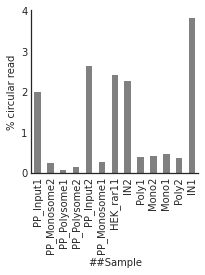

In [4]:
(stats_df['frac_circular']*100).plot.bar(figsize = (3,3), color = 'grey')
plt.ylabel('% circular read')
sns.despine()
plt.savefig(figdir/'6_ribo_fraction_circle.pdf')

In [5]:
counts = pd.concat(circ_type_count, axis = 1)
counts.columns = names

In [6]:
bsj = pd.concat(bsj_ratio_tbl, axis = 1)
bsj.columns = names

In [7]:
fsj = pd.concat(fsj_ratio_tbl, axis = 1)
fsj.columns = names

In [8]:
junc = pd.concat(junc_ratio_tbl, axis = 1)
junc.columns = names

In [9]:
bsj_cpm=bsj.div(stats_df['##Total_Reads'], axis = 1)*10**6
fsj_cpm=fsj.div(stats_df['##Total_Reads'], axis = 1)*10**6

# Types of circular RNA detected and basic statisics

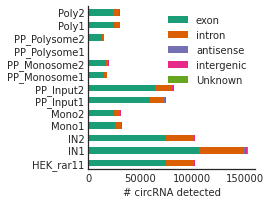

In [10]:
counts.T.sort_index().plot.barh(stacked = True, figsize = (3,3))
plt.xlabel('# circRNA detected')
sns.despine()
plt.savefig(figdir/'6_ribo_n_circle.pdf')

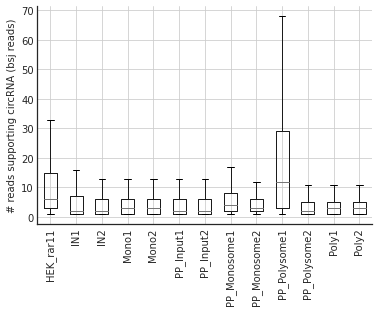

In [11]:
bsj.reindex(sorted(bsj.columns), axis=1).boxplot(showfliers=False, rot = 90)
plt.ylabel('# reads supporting circRNA (bsj reads)')
sns.despine()

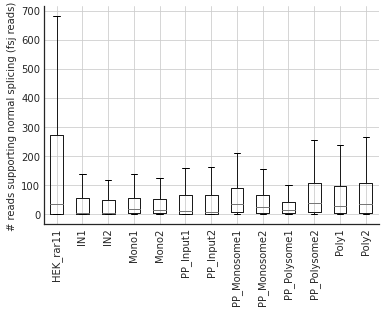

In [12]:
fsj.reindex(sorted(fsj.columns), axis=1).boxplot(showfliers=False, rot = 90)
plt.ylabel('# reads supporting normal splicing (fsj reads)')
sns.despine()

Text(0, 0.5, '(BSJ+1)/(FSJ+1)')

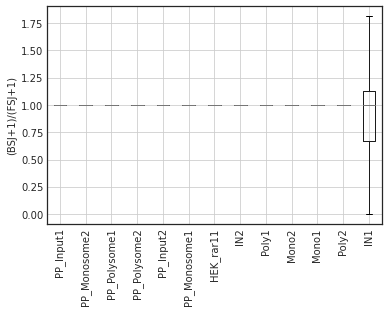

In [13]:
((bsj.fillna(0)+1)/(fsj.fillna(0)+1)).boxplot(showfliers=False, rot = 90)
plt.ylabel('(BSJ+1)/(FSJ+1)')

# CircRIP output: is not great

In [14]:
def read_circRIP_outputs(indir, sample1, sample2):
    rip_output = pd.read_csv(Path(indir)/'circRIP/'/f'{sample1}_vs_{sample2}',
    sep = '\t', names = ['circ_id', 'gene', 'BSJs in IP',
            'circRNA in Input','CPM in IP','CPM in Input',
            'IP/Input ratio','p-value', 'status'],
                comment = '>'
            )
    # annotation
    circ_df, stat = read_ciri_gtf(Path(indir)/f'{sample1}.gtf')
    rip_output = rip_output.merge(circ_df, left_on = 'circ_id', right_on = 'circ_id')
    return rip_output

In [15]:
monosome_output1_1 = read_circRIP_outputs(indir1, 'PP_Monosome1', 'PP_Input1')
monosome_output1_2 = read_circRIP_outputs(indir1, 'PP_Monosome2', 'PP_Input2')
polysome_output1_1 = read_circRIP_outputs(indir1, 'PP_Polysome1', 'PP_Input1')
polysome_output1_2 = read_circRIP_outputs(indir1, 'PP_Polysome2', 'PP_Input2')
monosome_output2_1 = read_circRIP_outputs(indir2, 'Mono1', 'IN1')
monosome_output2_2 = read_circRIP_outputs(indir2, 'Mono2', 'IN2')
polysome_output2_1 = read_circRIP_outputs(indir2, 'Poly1', 'IN1')
polysome_output2_2 = read_circRIP_outputs(indir2, 'Poly2', 'IN2')

In [16]:
all_rip_outputs = [monosome_output1_1, monosome_output1_2, polysome_output1_1, polysome_output1_2,
                  monosome_output2_1, monosome_output2_2, polysome_output2_1, polysome_output2_2]

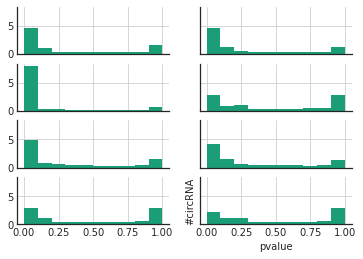

In [17]:
f, axes = plt.subplots(4,2, sharex = True, sharey = True)

for output, ax in zip(all_rip_outputs, axes.flatten()):
    output['p-value'].hist(ax=ax, density = True)
    
plt.xlabel('pvalue')
plt.ylabel('#circRNA')
sns.despine()

Text(0, 0.5, '# circular RNA')

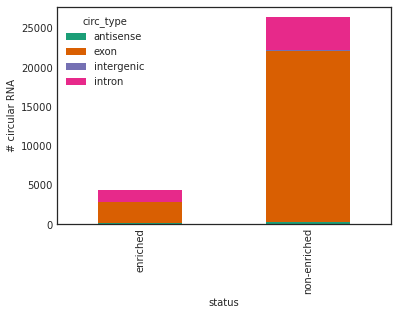

In [18]:
cnt = polysome_output2_1.groupby(by = ['circ_type', 'status']).count()['circ_id'].unstack()
cnt.T.plot.bar(stacked = True)
plt.ylabel('# circular RNA')

In [19]:
for output in all_rip_outputs:
    print(
        output.loc[(output['gene'].str.contains('ZNF609'))&(output['circ_id'].str.contains('166'))
                   
                   , ['circ_id', 'status', 'p-value']]
    )
# Chr15:64499292-64500166  is the one on literature

                      circ_id        status       p-value
5882  chr15:64499293|64500166  non-enriched  1.110223e-16
                      circ_id        status  p-value
6394  chr15:64499293|64500166  non-enriched  0.92012
Empty DataFrame
Columns: [circ_id, status, p-value]
Index: []
                      circ_id        status  p-value
4857  chr15:64499293|64500166  non-enriched      1.0
                       circ_id    status       p-value
10659  chr15:64499293|64500166  enriched  1.110223e-16
                       circ_id        status   p-value
10436  chr15:64499293|64500166  non-enriched  0.999838
                       circ_id    status       p-value
10298  chr15:64499293|64500166  enriched  1.110223e-16
                       circ_id        status  p-value
10104  chr15:64499293|64500166  non-enriched      1.0


# My outputs: Beta-binom

# TODO: run published dataset?

In [20]:
annot2 = pd.read_csv(Path(indir2)/'count_table.tsv', sep = '\t', index_col = 0)
my_monosome_output2_1 = pd.read_csv(Path(indir2) /'RIP/Mono1.IN1.csv', index_col = 0)
my_monosome_output2_2 = pd.read_csv(Path(indir2) /'RIP/Mono2.IN2.csv', index_col = 0)
my_polysome_output2_1 = pd.read_csv(Path(indir2) /'RIP/Poly1.IN1.csv', index_col = 0)
my_polysome_output2_2 = pd.read_csv(Path(indir2) /'RIP/Poly2.IN2.csv', index_col = 0)

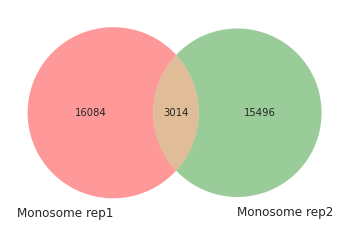

In [21]:
FDR_threshold = 0.2

venn2([set(my_monosome_output2_1.loc[my_monosome_output2_1['FDR']<FDR_threshold, 'circ_id']),
           set(my_monosome_output2_2.loc[my_monosome_output2_2['FDR']<FDR_threshold, 'circ_id'])
          ],set_labels = ['Monosome rep1', 'Monosome rep2'])


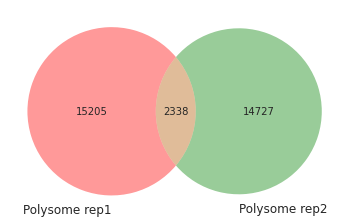

In [22]:
FDR_threshold = 0.2

venn2([set(my_polysome_output2_1.loc[my_polysome_output2_1['FDR']<FDR_threshold, 'circ_id']),
           set(my_polysome_output2_2.loc[my_polysome_output2_2['FDR']<FDR_threshold, 'circ_id'])
          ],set_labels = ['Polysome rep1', 'Polysome rep2'])


In [23]:
monosome_reproducible = set(my_monosome_output2_1.loc[my_monosome_output2_1['FDR']<FDR_threshold, 'circ_id']
                           ).intersection(set(my_monosome_output2_2.loc[my_monosome_output2_2['FDR']<FDR_threshold, 'circ_id'])
                                         )
polysome_reproducible = set(my_polysome_output2_1.loc[my_polysome_output2_1['FDR']<FDR_threshold, 'circ_id']
                           ).intersection(set(my_polysome_output2_2.loc[my_polysome_output2_2['FDR']<FDR_threshold, 'circ_id'])
                                         )
        

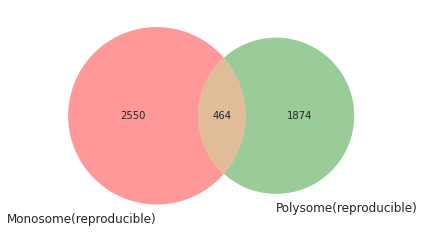

In [24]:
venn2([monosome_reproducible,
           polysome_reproducible
          ],set_labels = ['Monosome(reproducible)', 'Polysome(reproducible)'])
plt.savefig(figdir/'6_ribo_venn_mono_poly.pdf')

In [25]:
annot2['is_Monosome']=annot2['circ_id'].isin(monosome_reproducible)
annot2['is_Polysome']=annot2['circ_id'].isin(polysome_reproducible)

In [26]:
tested = set(my_monosome_output2_1.loc[my_monosome_output2_1['tested'], 'circ_id']).intersection(
    set(my_monosome_output2_2.loc[my_monosome_output2_2['tested'], 'circ_id'])).intersection(
    set(my_polysome_output2_1.loc[my_polysome_output2_1['tested'], 'circ_id'])).intersection(
    set(my_polysome_output2_2.loc[my_polysome_output2_2['tested'], 'circ_id']))

In [27]:
len(tested)

22023

In [28]:
circtype_counts = annot2.loc[annot2['circ_id'].isin(tested)].groupby(by = ['is_Monosome', 'is_Polysome'])['circ_type'].value_counts(
).unstack().fillna(0)

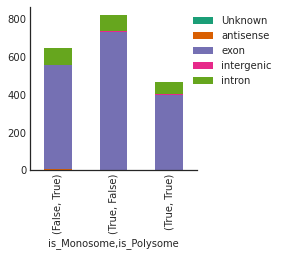

In [29]:
circtype_counts.iloc[1:,].plot.bar(stacked = True, figsize = (3,3))
plt.legend(bbox_to_anchor = (1.5, 1))
sns.despine()
plt.savefig(figdir/'6_ribo_enriched_circtype.pdf')

In [30]:
circtype_counts.div(circtype_counts.sum(axis = 1), axis = 0)

circ_type                Unknown  antisense      exon  intergenic    intron
is_Monosome is_Polysome                                                    
False       False         0.0001   0.001891  0.880986    0.004978  0.112046
            True          0.0000   0.009288  0.851393    0.004644  0.134675
True        False         0.0000   0.002430  0.883354    0.007290  0.106926
            True          0.0000   0.002155  0.859914    0.004310  0.133621

In [31]:
cont = pd.concat([circtype_counts.loc[:, circtype_counts.columns!='exon'].sum(axis = 1),
          circtype_counts['exon']], axis = 1)

In [32]:
cont

0     exon
is_Monosome is_Polysome                 
False       False        2391.0  17699.0
            True           96.0    550.0
True        False          96.0    727.0
            True           65.0    399.0

In [33]:
from scipy.stats import fisher_exact,chisquare
def testing(df):
    ''' perform fisher exact or chisq given contingency table'''
    if df.shape != (2,2):
        # some outcomes are unobserved
        print(df.shape)
        print('no binding is observed in')
        return 1, np.nan
    if df.le(5).any().any():
        odds_ratio, pvalue = fisher_exact(df)
    else:
        chi, pvalue = chisquare(df.loc[True], (df.loc[True].sum())*df.loc[False].div(df.loc[False].sum()))
        odds_ratio = (df.loc[True, True]/df.loc[True, False])/(df.loc[False, True]/df.loc[False, False])
    return pvalue, odds_ratio

In [34]:
annot2.loc[(annot2['gene_name']=='ZNF609')&(annot2['circ_id'].str.contains('166'))]

,seqname,source,feature,start,end,strand,frame,circ_id,circ_type,gene_id,...,BSJ-Poly2,BSJ-IN1,FSJ-IN2,FSJ-Poly1,FSJ-Mono2,FSJ-Mono1,FSJ-Poly2,FSJ-IN1,is_Monosome,is_Polysome
79609,chr15,CIRIquant,circRNA,64499293.0,64500166.0,+,.,chr15:64499293|64500166,exon,ENSG00000180357.9,...,39.0,24.0,20.0,50.0,24.0,0.0,33.0,0.0,False,False
119497,chr15,CIRIquant,circRNA,64495840.0,64500166.0,+,.,chr15:64495840|64500166,intron,ENSG00000180357.9,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,43.0,False,False


## Compare with published results

In [35]:
transcirc = pd.read_csv('transcirc_metadata.tsv', sep = '\t')
transcirc['circ_id']=transcirc['chrom']+':'+transcirc['start'].astype(str)+'|'+transcirc['end'].astype(str)
transcirc.drop_duplicates(subset = ['circ_id'], inplace = True)

In [36]:
all_data = pd.merge(transcirc, annot2[['circ_id', 'is_Monosome', 'is_Polysome']]
         , left_on = 'circ_id'
         , right_on = 'circ_id')
         

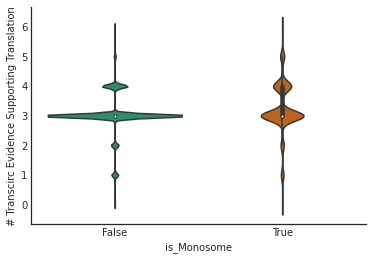

Text(0, 0.5, '# Transcirc Evidence Supporting Translation')

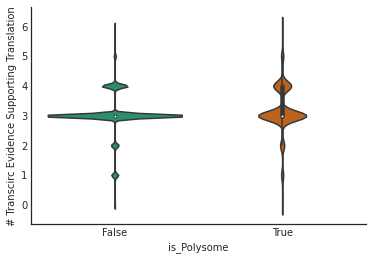

In [37]:
sns.violinplot(data = all_data, x = 'is_Monosome', y= 'evidences_num',
               figsize = (3,3)
             )
sns.despine()
plt.ylabel('# Transcirc Evidence Supporting Translation')
plt.show()
sns.violinplot(data = all_data, x = 'is_Polysome', y= 'evidences_num',
               figsize = (3,3)
             )
sns.despine()
plt.ylabel('# Transcirc Evidence Supporting Translation')

In [38]:
evidence_num_df = all_data.groupby(by = ['is_Monosome', 'is_Polysome']
                                  )['evidences_num'].value_counts().unstack().fillna(0)

In [39]:
evidence_num_df

evidences_num                0       1       2        3        4       5     6
is_Monosome is_Polysome                                                       
False       False        155.0  3559.0  4019.0  77831.0  13574.0  1006.0  29.0
            True           3.0    43.0    77.0   1017.0    286.0    28.0   1.0
True        False          1.0    79.0    83.0   1288.0    462.0   111.0   6.0
            True           0.0     9.0    26.0    185.0    160.0    28.0   3.0

In [40]:
evidence_rate_df = evidence_num_df.div(evidence_num_df.sum(axis = 1), axis = 0)

In [41]:
evidence_rate_df

evidences_num                   0         1         2         3         4  \
is_Monosome is_Polysome                                                     
False       False        0.001547  0.035529  0.040121  0.776966  0.135506   
            True         0.002062  0.029553  0.052921  0.698969  0.196564   
True        False        0.000493  0.038916  0.040887  0.634483  0.227586   
            True         0.000000  0.021898  0.063260  0.450122  0.389294   

evidences_num                   5         6  
is_Monosome is_Polysome                      
False       False        0.010043  0.000289  
            True         0.019244  0.000687  
True        False        0.054680  0.002956  
            True         0.068127  0.007299

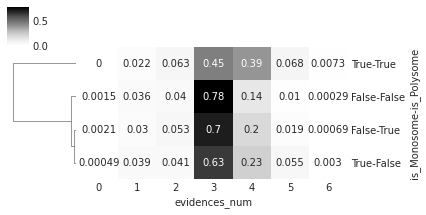

In [42]:
sns.clustermap(evidence_rate_df, col_cluster = False, cmap = 'Greys', annot = True,
              figsize = (6,3), metric = 'correlation')
plt.savefig(figdir/'6_ribo_transcirc_n_evidence.pdf')

In [43]:
all_data['4_or_more_evidence']=all_data['evidences_num']>=4

In [44]:
pv_mono, odds_mono = testing(
    all_data.groupby(by = ['is_Monosome', '4_or_more_evidence']).count()['circ_id'].unstack())
print(pv_mono, odds_mono)

1.8673732682675115e-122 2.6771220343055524


In [45]:
all_data['Both_Monosome_Polysome']=(all_data['is_Monosome'])&(all_data['is_Polysome'])

In [46]:
pv_poly, odds_poly = testing(all_data.groupby(
    by = ['is_Polysome', '4_or_more_evidence']).count()['circ_id'].unstack())
print(pv_poly, odds_poly)

4.1687393257039904e-50 2.1315972168430184


In [47]:
pv_both, odds_both = testing(all_data.groupby(
    by = ['Both_Monosome_Polysome', '4_or_more_evidence']).count()['circ_id'].unstack())
print(pv_both, odds_both)

8.952741136291884e-72 4.936758574586737


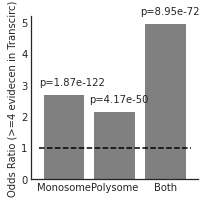

In [48]:
f, ax = plt.subplots(1,1, figsize = (3,3))
ax.bar(x = [0,1,2], height = [odds_mono, odds_poly, odds_both], color = 'grey')
plt.text(0-0.5, odds_mono+0.3, f'p={pv_mono:.2e}')
plt.text(1-0.5, odds_poly+0.3, f'p={pv_poly:.2e}')
plt.text(2-0.5, odds_both+0.3, f'p={pv_both:.2e}')
plt.ylabel('Odds Ratio (>=4 evidecen in Transcirc)')
plt.xticks([0,1,2], ['Monosome', 'Polysome', 'Both'])
plt.hlines(y = 1, xmin = -0.5, xmax = 2.5, linestyle = '--', color = 'black')
sns.despine()
plt.savefig(figdir/'6_ribo_transcirc_n_evidence_oddsratio.pdf')

In [49]:
m6A_num_df = all_data.groupby(by = ['is_Monosome', 'is_Polysome'])['m6A'].value_counts().unstack().fillna(0)
m6A_num_df

m6A                        0.0    1.0
is_Monosome is_Polysome              
False       False        89757  10416
            True          1291    164
True        False         1686    344
            True           346     65

In [50]:
all_data['m6A'] = (all_data['m6A']>0)
pv_poly_m6A, odds_poly_m6A = testing(all_data.groupby(by = ['is_Polysome', 'm6A']).count()['circ_id'].unstack())
pv_mono_m6A, odds_mono_m6A  = testing(all_data.groupby(by = ['is_Monosome', 'm6A']).count()['circ_id'].unstack())
pv_both_m6A, odds_both_m6A  = testing(all_data.groupby(by = ['Both_Monosome_Polysome', 'm6A']).count()['circ_id'].unstack())

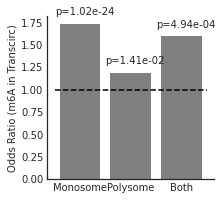

In [51]:
f, ax = plt.subplots(1,1, figsize = (3,3))
ax.bar(x = [0,1,2], height = [odds_mono_m6A, odds_poly_m6A, odds_both_m6A], color = 'grey')
plt.text(0-0.5, odds_mono_m6A+0.1, f'p={pv_mono_m6A:.2e}')
plt.text(1-0.5, odds_poly_m6A+0.1, f'p={pv_poly_m6A:.2e}')
plt.text(2-0.5, odds_both_m6A+0.1, f'p={pv_both_m6A:.2e}')
plt.ylabel('Odds Ratio (m6A in Transcirc)')
plt.xticks([0,1,2], ['Monosome', 'Polysome', 'Both'])
plt.hlines(y = 1, xmin = -0.5, xmax = 2.5, linestyle = '--', color = 'black')
sns.despine()
plt.savefig(figdir/'6_ribo_transcirc_m6A_oddsratio.pdf')

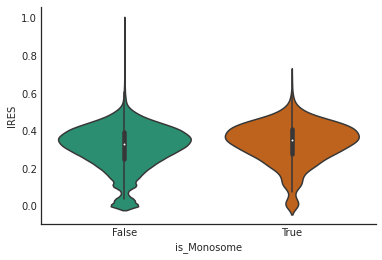

In [52]:
sns.violinplot(data = all_data, x = 'is_Monosome', y= 'IRES',
             )
sns.despine()

# the sum of z-score


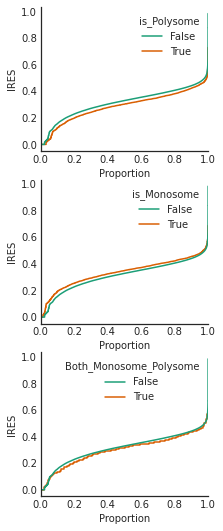

In [53]:
f, ax = plt.subplots(3,1, figsize = (3,9))
sns.ecdfplot(data = all_data, hue = 'is_Polysome', y= 'IRES',
             ax = ax[0]
             )
sns.ecdfplot(data = all_data, hue = 'is_Monosome', y= 'IRES',
             ax = ax[1]
             )
sns.ecdfplot(data = all_data, hue = 'Both_Monosome_Polysome', y= 'IRES',
             ax = ax[2]
             )
sns.despine()
plt.savefig(figdir/'6_ribo_transcirc_ires_ecdf.pdf')

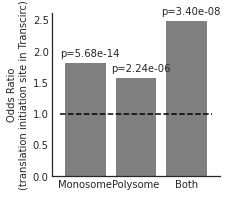

In [54]:
#translation initiation site
all_data['TIS'] = all_data['TIS'].map({0:False, 1:True})
pv_poly_tis, odds_poly_tis = testing(
    all_data.groupby(by = ['is_Polysome', 'TIS']).count()['circ_id'].unstack())
pv_mono_tis, odds_mono_tis  = testing(
    all_data.groupby(by = ['is_Monosome', 'TIS']).count()['circ_id'].unstack())
pv_both_tis, odds_both_tis  = testing(
    all_data.groupby(by = ['Both_Monosome_Polysome', 'TIS']).count()['circ_id'].unstack())

f, ax = plt.subplots(1,1, figsize = (3,3))
ax.bar(x = [0,1,2], height = [odds_mono_tis, odds_poly_tis, odds_both_tis], color = 'grey')
plt.text(0-0.5, odds_mono_tis+0.1, f'p={pv_mono_tis:.2e}')
plt.text(1-0.5, odds_poly_tis+0.1, f'p={pv_poly_tis:.2e}')
plt.text(2-0.5, odds_both_tis+0.1, f'p={pv_both_tis:.2e}')
plt.ylabel('Odds Ratio\n(translation initiation site in Transcirc)')
plt.xticks([0,1,2], ['Monosome', 'Polysome', 'Both'])
plt.hlines(y = 1, xmin = -0.5, xmax = 2.5, linestyle = '--', color = 'black')
sns.despine()
plt.savefig(figdir/'6_ribo_transcirc_TIS_oddsratio.pdf')

In [55]:
all_data['RP/RP']

0         0.000000
1         0.333333
2         0.000000
3         0.000000
4         0.000000
            ...   
104064    0.000000
104065    0.000000
104066    0.000000
104067    0.000000
104068    0.000000
Name: RP/RP, Length: 104069, dtype: float64

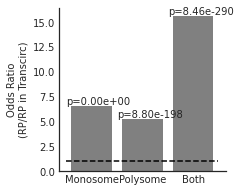

In [56]:
all_data['is_RP']=all_data['RP/RP']>0

pv_poly_rp, odds_poly_rp = testing(
    all_data.groupby(by = ['is_Polysome', 'is_RP']).count()['circ_id'].unstack())
pv_mono_rp, odds_mono_rp  = testing(
    all_data.groupby(by = ['is_Monosome', 'is_RP']).count()['circ_id'].unstack())
pv_both_rp, odds_both_rp  = testing(
    all_data.groupby(by = ['Both_Monosome_Polysome', 'is_RP']).count()['circ_id'].unstack())

f, ax = plt.subplots(1,1, figsize = (3,3))
ax.bar(x = [0,1,2], height = [odds_mono_rp, odds_poly_rp, odds_both_rp], color = 'grey')
plt.text(0-0.5, odds_mono_rp+0.1, f'p={pv_mono_rp:.2e}')
plt.text(1-0.5, odds_poly_rp+0.1, f'p={pv_poly_rp:.2e}')
plt.text(2-0.5, odds_both_rp+0.1, f'p={pv_both_rp:.2e}')
plt.ylabel('Odds Ratio\n(RP/RP in Transcirc)')
plt.xticks([0,1,2], ['Monosome', 'Polysome', 'Both'])
plt.hlines(y = 1, xmin = -0.5, xmax = 2.5, linestyle = '--', color = 'black')
sns.despine()
plt.savefig(figdir/'6_ribo_transcirc_RP_oddsratio.pdf')

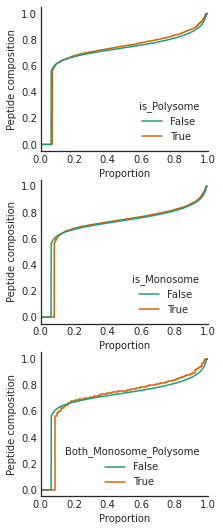

In [57]:
f, ax = plt.subplots(3,1, figsize = (3,9))
sns.ecdfplot(data = all_data, hue = 'is_Polysome', y= 'Peptide composition',
             ax = ax[0]
             )
sns.ecdfplot(data = all_data, hue = 'is_Monosome', y= 'Peptide composition',
             ax = ax[1]
             )
sns.ecdfplot(data = all_data, hue = 'Both_Monosome_Polysome', y= 'Peptide composition',
             ax = ax[2]
             )
sns.despine()
plt.savefig(figdir/'6_ribo_transcirc_peptide_comp_ecdf.pdf')

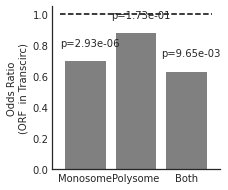

In [58]:
all_data['ORF'] = all_data['ORF'].map({0:False, 1:True})


pv_poly_rp, odds_poly_rp = testing(
    all_data.groupby(by = ['is_Polysome', 'ORF']).count()['circ_id'].unstack())
pv_mono_rp, odds_mono_rp  = testing(
    all_data.groupby(by = ['is_Monosome', 'ORF']).count()['circ_id'].unstack())
pv_both_rp, odds_both_rp  = testing(
    all_data.groupby(by = ['Both_Monosome_Polysome', 'ORF']).count()['circ_id'].unstack())

f, ax = plt.subplots(1,1, figsize = (3,3))
ax.bar(x = [0,1,2], height = [odds_mono_rp, odds_poly_rp, odds_both_rp], color = 'grey')
plt.text(0-0.5, odds_mono_rp+0.1, f'p={pv_mono_rp:.2e}')
plt.text(1-0.5, odds_poly_rp+0.1, f'p={pv_poly_rp:.2e}')
plt.text(2-0.5, odds_both_rp+0.1, f'p={pv_both_rp:.2e}')
plt.ylabel('Odds Ratio\n(ORF  in Transcirc)')
plt.xticks([0,1,2], ['Monosome', 'Polysome', 'Both'])
plt.hlines(y = 1, xmin = -0.5, xmax = 2.5, linestyle = '--', color = 'black')
sns.despine()
plt.savefig(figdir/'6_ribo_transcirc_ORF_oddsratio.pdf')

In [59]:
all_data.to_csv(figdir / '6_mono_poly_circ.csv')

In [60]:
figdir / '6_mono_poly_circ.csv'

PosixPath('/home/hsher/scratch/circular_fig/6_mono_poly_circ.csv')

In [61]:
all_data.head()

,TransCirc_ID,xref,species,gene,strand,gene_id,chrom,start,end,evidences_num,...,ORF,IRES,Peptide composition,MS,circ_id,is_Monosome,is_Polysome,4_or_more_evidence,Both_Monosome_Polysome,is_RP
0,TC-hsa-ISG15_0003,circAtlas:hsa-ISG15_0004,Homo sapiens,ISG15,+,ENSG00000187608.8,chr1,1008194,1009370,3,...,True,0.067883,0.703689,0.0,chr1:1008194|1009370,False,False,False,False,False
1,TC-hsa-SDF4_0002,circAtlas:hsa-SDF4_0001; circBase:hsa_circ_000...,Homo sapiens,SDF4,-,ENSG00000078808.16,chr1,1223244,1223968,4,...,True,0.126974,0.760439,0.0,chr1:1223244|1223968,True,True,True,True,True
2,TC-hsa-SSU72_0004,circAtlas:hsa-SSU72_0001,Homo sapiens,SSU72,-,ENSG00000160075.11,chr1,1564605,1564916,3,...,True,0.132054,0.685980,0.0,chr1:1564605|1564916,False,False,False,False,False
3,TC-hsa-CDK11B_0001,circAtlas:hsa-CDK11B_0011,Homo sapiens,CDK11B,-,ENSG00000248333.8,chr1,1636682,1640452,3,...,True,0.267729,0.717884,0.0,chr1:1636682|1640452,False,False,False,False,False
4,TC-hsa-SLC35E2B_0005,circAtlas:hsa-SLC35E2B_0006; circpedia2:HSA_CI...,Homo sapiens,SLC35E2B,-,ENSG00000189339.11,chr1,1671509,1676846,3,...,True,0.166007,0.691670,0.0,chr1:1671509|1676846,False,False,False,False,False
